# Assignment 4 Image Classification DL Framework

*(Deep Learning (80240743), Spring 2023)*  
Due at **23:55, April 7, 2023**  


## Instructions

 image classification on both MNIST and CIFAR-10 
 
Submit **all code, pretrained models, and a report** with the following requirements:

-   Implement at least one MLP and one CNN, set reasonable hyperparameters, and record  
    their training and testing results. Plot their accuracy and loss curves.

-   Compare the performance of CNN under various settings and record your observations.  
    Your comparison should be carried out on no less than 3 aspects, including but not  
    limited to the number of layers/kernels, activation functions, losses, optimizers, etc.

Supply your report with data and graphs if necessary. 

attach environment.yml too. everythign else is immediately obvious from the function names etc.


## Preparing datasets

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
from torchvision import datasets
import numpy as np
import sklearn.metrics
from matplotlib import pyplot as plt

from pdb import set_trace as st

In [2]:
batch_size=16
device = 'cuda'

In [3]:
data_dir = './data'
mnist_train = datasets.MNIST(root=data_dir, train=True, download=True, transform=ToTensor())
mnist_test = datasets.MNIST(root=data_dir, train=False, download=True, transform=ToTensor())
cifar_train = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=ToTensor())
cifar_test = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(mnist_train), len(cifar_train)

(60000, 50000)

In [5]:
mnist_train, mnist_val = random_split(mnist_train, [54000,6000])
cifar_train, cifar_val = random_split(cifar_train, [45000,5000])

In [6]:
mnist_train_dl = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
mnist_val_dl = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, drop_last=True)
mnist_test_dl = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)
cifar_train_dl = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, drop_last=True)
cifar_val_dl = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, drop_last=True)
cifar_test_dl = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, drop_last=True)

In [7]:
a, b = next(iter(mnist_train_dl))
a.shape, b.shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

In [8]:
a, b = next(iter(cifar_train_dl))
a.shape, b.shape, b

(torch.Size([16, 3, 32, 32]),
 torch.Size([16]),
 tensor([0, 4, 9, 5, 7, 8, 9, 0, 5, 0, 3, 0, 8, 9, 6, 3]))

## Models

In [9]:
class MLP(torch.nn.Module):
    def __init__(self, mnist=True):
        super(MLP, self).__init__()
        if mnist:
            self.inp_size = 784
        else:
            self.inp_size = 3072
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(self.inp_size, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10),
            torch.nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = x.view(-1, self.inp_size)
        x = self.layers(x)
        return x

In [10]:
class CNN(torch.nn.Module):
    def __init__(self, mnist=True, relu=True):
        super(CNN, self).__init__()
        if relu:
            act = torch.nn.ReLU
        else:
            act = torch.nn.Sigmoid
            
        if mnist:
            first_chan = 1
            self.img_dim = 5
        else:
            first_chan = 3
            self.img_dim = 6
        
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv2d(first_chan, 6, 5), # 32x32 -> 28x28 / 28x28 -> 24x24
            act(),
            torch.nn.MaxPool2d(2),# 28x28 -> 14x14 / 24x24 -> 12x12
            torch.nn.Conv2d(6, 16, 3), # 14x14 -> 12x12 / 12x12 -> 10x10
            act(),
            torch.nn.MaxPool2d(2) # 12x12 -> 6x6 / 10x10 -> 5x5
        )
        
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(self.img_dim * self.img_dim * 16, 128),
            act(),
            torch.nn.Linear(128, 10),
            torch.nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, self.img_dim * self.img_dim * 16)
        x = self.fc_layers(x)
        return x

## Training/testing utility code

In [12]:
def plot_graph(train_losses, val_losses, val_accs):
    max_epoch = len(train_losses)
    
    plt.subplot(1,2,1)
    plt.title('Losses')
    plt.plot(train_losses, marker='.', label='train')
    plt.plot(val_losses, marker='.', label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.title('Validation Accuracies')
    plt.plot(val_accs, marker='.')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')


def train(model, loss_fn, opt_class, mnist=True, epochs=5, lr=0.001):
    model = model.to(device)
    opt = opt_class(model.parameters(), lr=lr)
    
    if isinstance(loss_fn, torch.nn.MSELoss):
        lr *= 20
    
    if mnist:
        train_dl = mnist_train_dl
        val_dl = mnist_val_dl
        test_dl = mnist_test_dl
    else:
        train_dl = cifar_train_dl
        val_dl = cifar_val_dl
        test_dl = cifar_test_dl
    
    train_losses = []
    val_losses = []
    val_accs = []
    
    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_val_loss = 0
        acc = 0
        for x,y in train_dl:
            opt.zero_grad()

            x = x.to(device)
            y = y.to(device)
            xhat = model(x)
            
            if isinstance(loss_fn, torch.nn.CrossEntropyLoss):
                loss = loss_fn(xhat, y)
            else:
                new_y = torch.zeros(xhat.shape, device=device)[y]
                new_y[torch.arange(batch_size, device=device), y] = 1
                loss = loss_fn(xhat, new_y)

            loss.backward()
            opt.step()
            
            epoch_train_loss += float(loss.item())
        
        for x,y in val_dl:
            x = x.to(device)
            y = y.to(device)
            xhat = model(x)
            
            if isinstance(loss_fn, torch.nn.CrossEntropyLoss):
                loss = loss_fn(xhat, y)
            else:
                new_y = torch.zeros(xhat.shape, device=device)[y]
                new_y[torch.arange(batch_size, device=device), y] = 1
                loss = loss_fn(xhat, new_y)
                
            epoch_val_loss += float(loss.item())
            
            acc += sklearn.metrics.accuracy_score(
                np.argmax(xhat.detach().cpu().numpy(),1),  
                y.detach().cpu().numpy())
        
        epoch_train_loss /= len(train_dl)
        epoch_val_loss /= len(val_dl)
        acc /= len(val_dl)

        print(f'Epoch {epoch}, trainloss {epoch_train_loss}, valloss {epoch_val_loss}, valacc {acc}')
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        val_accs.append(acc)
    
    acc = 0
    for x,y in test_dl:
        x = x.to(device)
        y = y.to(device)
        xhat = model(x)

        acc += sklearn.metrics.accuracy_score(
            np.argmax(xhat.detach().cpu().numpy(),1),
            y.detach().cpu().numpy())

    acc /= len(test_dl)
    
    plot_graph(train_losses, val_losses, val_accs)

    print(f'Testacc {acc}')
    return train_losses, val_losses, val_accs, acc


## Experiments (MNIST)

Epoch 0, trainloss 0.010978046423775712, valloss 0.0060568081207936, valacc 0.9598333333333333
Epoch 1, trainloss 0.00526514238547916, valloss 0.004485936622184567, valacc 0.9718333333333333
Epoch 2, trainloss 0.004089854583731976, valloss 0.005170500393288682, valacc 0.9688333333333333
Epoch 3, trainloss 0.003456054802635382, valloss 0.004288149911238822, valacc 0.9731666666666666
Epoch 4, trainloss 0.002950411238116976, valloss 0.0040392117125363355, valacc 0.976
Epoch 5, trainloss 0.0027293862986274525, valloss 0.0039874027927425905, valacc 0.9763333333333334
Epoch 6, trainloss 0.0025375709347878507, valloss 0.00418012687759921, valacc 0.9746666666666667
Epoch 7, trainloss 0.0025315514511092428, valloss 0.003539564317517171, valacc 0.9798333333333333
Epoch 8, trainloss 0.0024080447419915544, valloss 0.003422591643145653, valacc 0.9808333333333333
Epoch 9, trainloss 0.0022326160523022487, valloss 0.004035214045652447, valacc 0.977
Testacc 0.9709


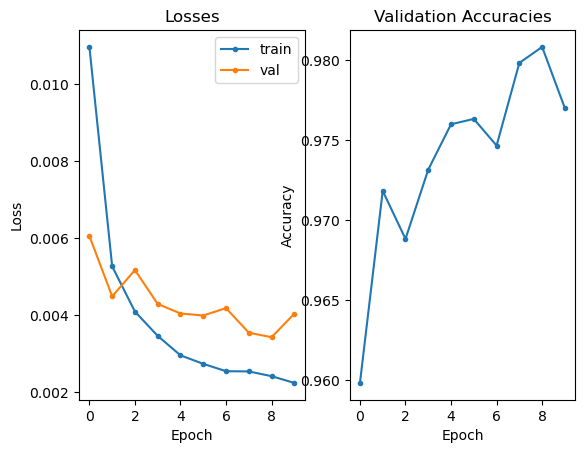

In [19]:
train_losses, val_losses, val_accs, test_acc = train(
    MLP(mnist=True),
    torch.nn.MSELoss(),
    torch.optim.Adam,
    mnist=True,
    epochs=10
)


Epoch 0, trainloss 1.5552654847392329, valloss 1.4994974641799927, valacc 0.9641666666666666
Epoch 1, trainloss 1.4945416812190304, valloss 1.4854603242874145, valacc 0.976
Epoch 2, trainloss 1.4864494350221422, valloss 1.4839490947723388, valacc 0.9775
Epoch 3, trainloss 1.4824435735631871, valloss 1.4809022970199586, valacc 0.98
Epoch 4, trainloss 1.4802613895204333, valloss 1.4794481163024902, valacc 0.9818333333333333
Epoch 5, trainloss 1.4782684537393076, valloss 1.479306886990865, valacc 0.9816666666666667
Epoch 6, trainloss 1.4761993757530496, valloss 1.480620811144511, valacc 0.9805
Epoch 7, trainloss 1.4760314481523302, valloss 1.476956995010376, valacc 0.9841666666666666
Epoch 8, trainloss 1.4751821110690082, valloss 1.476001903216044, valacc 0.9855
Epoch 9, trainloss 1.4748302769484343, valloss 1.4760319207509358, valacc 0.9846666666666667
Testacc 0.9859


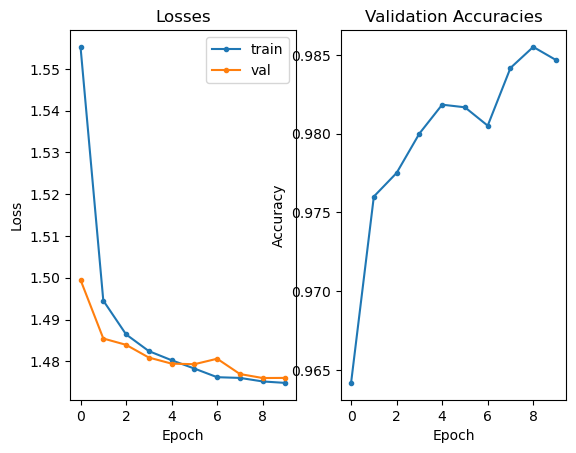

In [13]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=True),
    torch.nn.CrossEntropyLoss(),
    torch.optim.Adam,
    mnist=True,
    epochs=10
)


Epoch 0, trainloss 1.7684437618608828, valloss 1.5798429727554322, valacc 0.8976666666666666
Epoch 1, trainloss 1.5547341918945312, valloss 1.534946341196696, valacc 0.9335
Epoch 2, trainloss 1.5239970276090833, valloss 1.5114249261220296, valacc 0.9548333333333333
Epoch 3, trainloss 1.5071536693219785, valloss 1.5037788887023926, valacc 0.9615
Epoch 4, trainloss 1.4967008160838375, valloss 1.495494064648946, valacc 0.9673333333333334
Epoch 5, trainloss 1.490387801029064, valloss 1.4903043184280396, valacc 0.9733333333333334
Epoch 6, trainloss 1.4860830574388857, valloss 1.4863208901087444, valacc 0.9773333333333334
Epoch 7, trainloss 1.482433096603111, valloss 1.4844799830118816, valacc 0.979
Epoch 8, trainloss 1.4800744601355658, valloss 1.4814016936620076, valacc 0.9816666666666667
Epoch 9, trainloss 1.4786973011935198, valloss 1.4814541597366333, valacc 0.9815
Testacc 0.9845


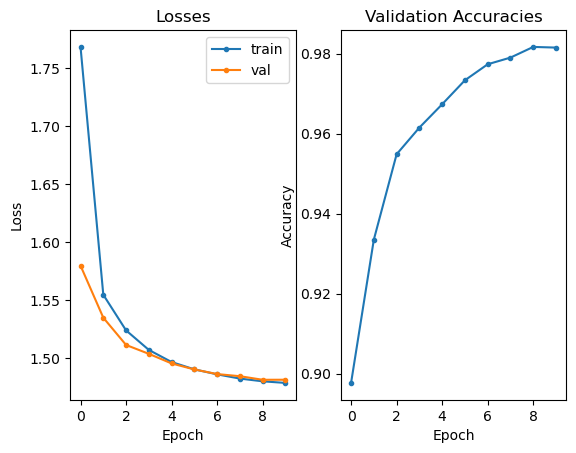

In [14]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=True, relu=False),
    torch.nn.CrossEntropyLoss(),
    torch.optim.Adam,
    mnist=True,
    epochs=10
)


Epoch 0, trainloss 0.009306262286769933, valloss 0.0038921690326785665, valacc 0.975
Epoch 1, trainloss 0.003385863871029596, valloss 0.0028526994155067768, valacc 0.9813333333333333
Epoch 2, trainloss 0.0024897366402574007, valloss 0.0022361254435442957, valacc 0.9856666666666667
Epoch 3, trainloss 0.002028244314582814, valloss 0.0023099604564781103, valacc 0.9853333333333333
Epoch 4, trainloss 0.001782119123039816, valloss 0.00219736547833309, valacc 0.9866666666666667
Epoch 5, trainloss 0.0014257489694367302, valloss 0.0019345153431147102, valacc 0.9875
Epoch 6, trainloss 0.0013583520404829865, valloss 0.0020851987313737666, valacc 0.9871666666666666
Epoch 7, trainloss 0.001105532091062941, valloss 0.0019674545368349905, valacc 0.9876666666666667
Epoch 8, trainloss 0.0011227378453615466, valloss 0.002025475721817138, valacc 0.987
Epoch 9, trainloss 0.000883937420196091, valloss 0.002298587246198056, valacc 0.9863333333333333
Testacc 0.9881


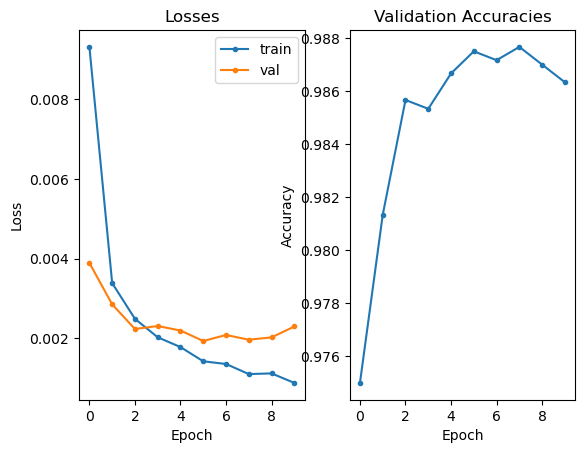

In [15]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=True),
    torch.nn.MSELoss(),
    torch.optim.Adam,
    mnist=True,
    epochs=10
)


Epoch 0, trainloss 0.0271746163412312, valloss 0.008282064880710096, valacc 0.9466666666666667
Epoch 1, trainloss 0.006461653974493081, valloss 0.0054471513987664364, valacc 0.9656666666666667
Epoch 2, trainloss 0.004592681488943459, valloss 0.0038280699992610605, valacc 0.9766666666666667
Epoch 3, trainloss 0.003607943195047348, valloss 0.00380771361099202, valacc 0.9756666666666667
Epoch 4, trainloss 0.0030276003927034016, valloss 0.0033699840042566696, valacc 0.9776666666666667
Epoch 5, trainloss 0.0026339338054450832, valloss 0.003122931388225273, valacc 0.9805
Epoch 6, trainloss 0.0022914226610616373, valloss 0.0027206647680484367, valacc 0.9823333333333333
Epoch 7, trainloss 0.0020263161336694993, valloss 0.0024824029306082214, valacc 0.9833333333333333
Epoch 8, trainloss 0.0018232451260577957, valloss 0.002656319507480248, valacc 0.983
Epoch 9, trainloss 0.0016228263014251522, valloss 0.0026876235008701883, valacc 0.9816666666666667
Testacc 0.9869


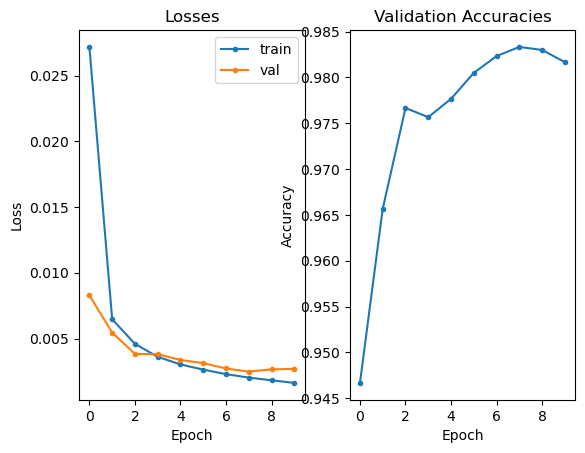

In [16]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=True, relu=False),
    torch.nn.MSELoss(),
    torch.optim.Adam,
    mnist=True,
    epochs=10
)


Epoch 0, trainloss 2.3023760557527897, valloss 2.3021581446329753, valacc 0.109
Epoch 1, trainloss 2.3020878578468604, valloss 2.301861986796061, valacc 0.141
Epoch 2, trainloss 2.3017860906389025, valloss 2.3015434106190997, valacc 0.17883333333333334
Epoch 3, trainloss 2.3014519537466542, valloss 2.3011786670684815, valacc 0.201
Epoch 4, trainloss 2.3010547892252604, valloss 2.3007307898203533, valacc 0.232
Epoch 5, trainloss 2.3005635050314446, valloss 2.3001768080393474, valacc 0.25733333333333336
Epoch 6, trainloss 2.2999571329752606, valloss 2.2994817905426026, valacc 0.2793333333333333
Epoch 7, trainloss 2.2991671095247623, valloss 2.298536876042684, valacc 0.29383333333333334
Epoch 8, trainloss 2.2980527609365957, valloss 2.2971492284139, valacc 0.3378333333333333
Epoch 9, trainloss 2.29633350859748, valloss 2.294896208445231, valacc 0.3565
Testacc 0.348


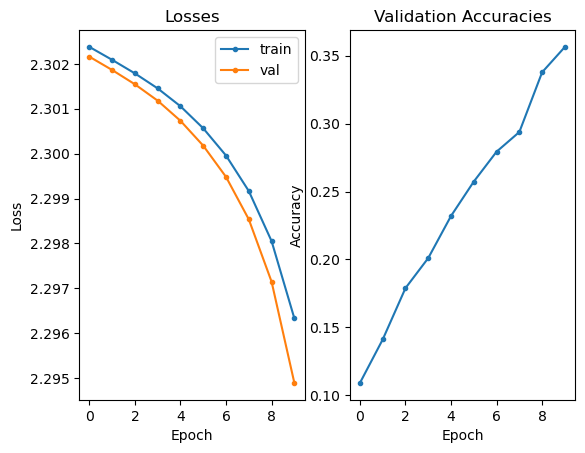

In [17]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=True),
    torch.nn.CrossEntropyLoss(),
    torch.optim.SGD,
    mnist=True,
    epochs=10
)


Epoch 0, trainloss 2.3020048607013845, valloss 2.302144110361735, valacc 0.09816666666666667
Epoch 1, trainloss 2.3018112523820666, valloss 2.3018166929880777, valacc 0.09816666666666667
Epoch 2, trainloss 2.301660179420754, valloss 2.3015446383158364, valacc 0.12033333333333333
Epoch 3, trainloss 2.3015540323610657, valloss 2.3013464024861654, valacc 0.12033333333333333
Epoch 4, trainloss 2.30148445087009, valloss 2.301194372812907, valacc 0.12033333333333333
Epoch 5, trainloss 2.301439518045496, valloss 2.301094467798869, valacc 0.12033333333333333
Epoch 6, trainloss 2.3014098329190853, valloss 2.301027022679647, valacc 0.12033333333333333
Epoch 7, trainloss 2.3013906731782137, valloss 2.3009868189493816, valacc 0.12033333333333333
Epoch 8, trainloss 2.301375516326339, valloss 2.300957198460897, valacc 0.12033333333333333
Epoch 9, trainloss 2.301363330346567, valloss 2.300926447550456, valacc 0.12033333333333333
Testacc 0.1135


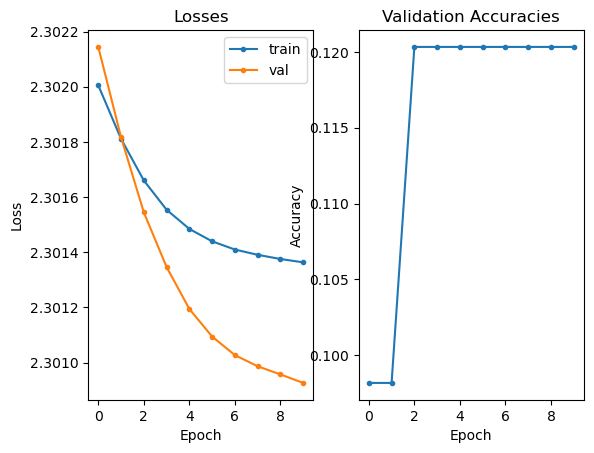

In [18]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=True, relu=False),
    torch.nn.CrossEntropyLoss(),
    torch.optim.SGD,
    mnist=True,
    epochs=10
)


Epoch 0, trainloss 0.09007261896133423, valloss 0.09005239647626877, valacc 0.0685
Epoch 1, trainloss 0.09005999513467153, valloss 0.09004022685686747, valacc 0.0745
Epoch 2, trainloss 0.09004748277752488, valloss 0.09002814547220866, valacc 0.08066666666666666
Epoch 3, trainloss 0.09003504110707176, valloss 0.09001611816883087, valacc 0.08616666666666667
Epoch 4, trainloss 0.09002263508019624, valloss 0.09000411568085352, valacc 0.08933333333333333
Epoch 5, trainloss 0.09001022772435789, valloss 0.08999210721254348, valacc 0.09333333333333334
Epoch 6, trainloss 0.08999778457924172, valloss 0.0899800644715627, valacc 0.09766666666666667
Epoch 7, trainloss 0.08998527524206373, valloss 0.08996793985366822, valacc 0.1025
Epoch 8, trainloss 0.08997267719551369, valloss 0.08995571704705556, valacc 0.107
Epoch 9, trainloss 0.08995997043009157, valloss 0.08994337491194407, valacc 0.11066666666666666
Testacc 0.1045


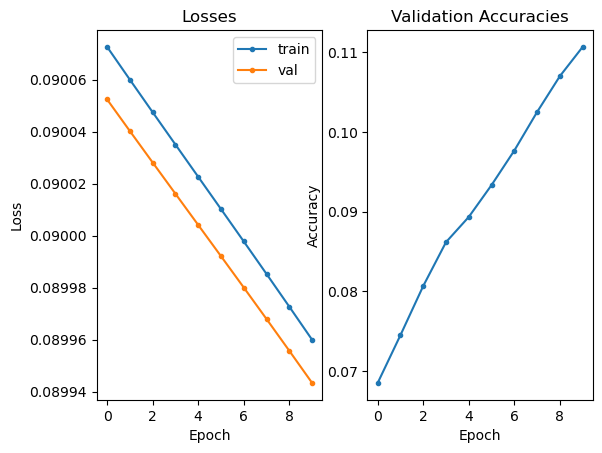

In [9]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=True),
    torch.nn.MSELoss(),
    torch.optim.SGD,
    mnist=True,
    epochs=10
)


Epoch 0, trainloss 0.09023496458044758, valloss 0.09018788148959478, valacc 0.09816666666666667
Epoch 1, trainloss 0.09013029607357802, valloss 0.09010843739906947, valacc 0.09816666666666667
Epoch 2, trainloss 0.09006792090777997, valloss 0.09006079739332198, valacc 0.09816666666666667
Epoch 3, trainloss 0.09003017531280165, valloss 0.09003193859259287, valacc 0.09816666666666667
Epoch 4, trainloss 0.09000730871271204, valloss 0.09001444544394811, valacc 0.09816666666666667
Epoch 5, trainloss 0.08999347287416458, valloss 0.09000394501288732, valacc 0.11133333333333334
Epoch 6, trainloss 0.08998515424905, valloss 0.08999764651060105, valacc 0.11133333333333334
Epoch 7, trainloss 0.08998015694706528, valloss 0.08999382676680882, valacc 0.11133333333333334
Epoch 8, trainloss 0.08997718794257553, valloss 0.0899915426770846, valacc 0.11133333333333334
Epoch 9, trainloss 0.08997540173707184, valloss 0.08999011480808258, valacc 0.11133333333333334
Testacc 0.1135


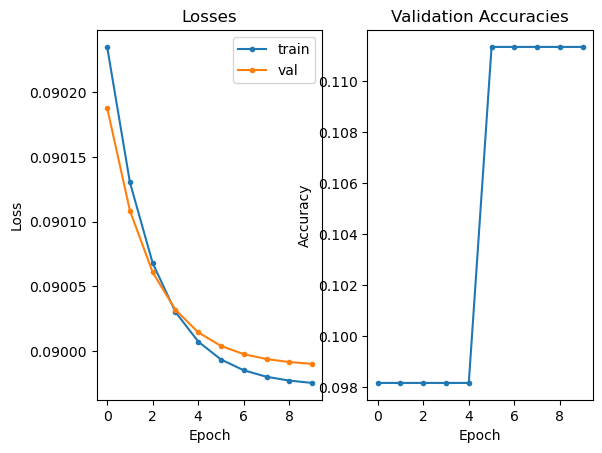

In [10]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=True, relu=False),
    torch.nn.MSELoss(),
    torch.optim.SGD,
    mnist=True,
    epochs=10
)


## Experiments (CIFAR)

Epoch 0, trainloss 0.08002088152953181, valloss 0.07689416350032656, valacc 0.3541666666666667
Epoch 1, trainloss 0.07483733024522345, valloss 0.07357350826406708, valacc 0.3948317307692308
Epoch 2, trainloss 0.07283244233785109, valloss 0.07278398073350008, valacc 0.405849358974359
Epoch 3, trainloss 0.07144071603032255, valloss 0.07057211657938285, valacc 0.42688301282051283
Epoch 4, trainloss 0.0702053995744708, valloss 0.07073623257187697, valacc 0.4208733974358974
Epoch 5, trainloss 0.0695144088970627, valloss 0.07062790364934465, valacc 0.43028846153846156
Epoch 6, trainloss 0.06882355062643418, valloss 0.06916010812020455, valacc 0.4387019230769231
Epoch 7, trainloss 0.06796305639878615, valloss 0.06843245089149629, valacc 0.4577323717948718
Epoch 8, trainloss 0.06743591944693693, valloss 0.0685602181758254, valacc 0.4547275641025641
Epoch 9, trainloss 0.0670742125715398, valloss 0.06795116209496672, valacc 0.46374198717948717
Testacc 0.4562


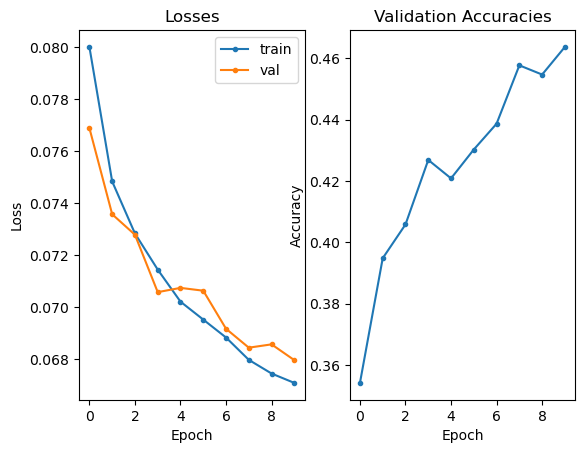

In [21]:
train_losses, val_losses, val_accs, test_acc = train(
    MLP(mnist=False),
    torch.nn.MSELoss(),
    torch.optim.Adam,
    mnist=False,
    epochs=10
)


Epoch 0, trainloss 2.1472923926852836, valloss 2.0612495612031734, valacc 0.38777955271565495
Epoch 1, trainloss 2.051278488177487, valloss 2.0306433020308376, valacc 0.4241214057507987
Epoch 2, trainloss 2.0177957175933208, valloss 2.0252167173087026, valacc 0.4335063897763578
Epoch 3, trainloss 1.9935419670085317, valloss 2.0093925799043797, valacc 0.44528753993610226
Epoch 4, trainloss 1.9714769445786136, valloss 1.9791058461887006, valacc 0.4788338658146965
Epoch 5, trainloss 1.9546176857088877, valloss 1.9558831967484838, valacc 0.5031948881789138
Epoch 6, trainloss 1.9411697124104206, valloss 1.936967280345222, valacc 0.5185702875399361
Epoch 7, trainloss 1.9245278954802567, valloss 1.9525418041613156, valacc 0.505591054313099
Epoch 8, trainloss 1.9127513961439406, valloss 1.951454820724341, valacc 0.5053913738019169
Epoch 9, trainloss 1.901691998784499, valloss 1.920067501906008, valacc 0.5369408945686901
Testacc 0.5368


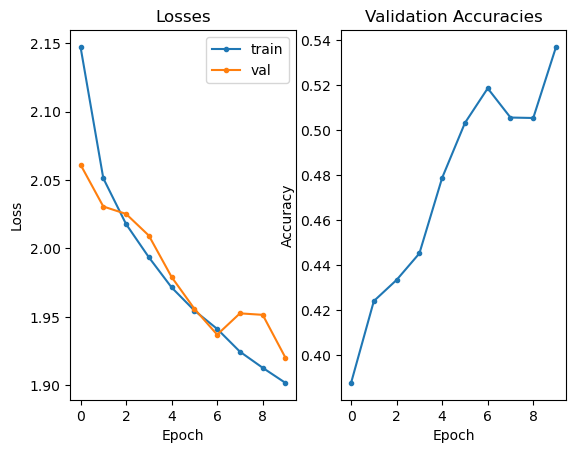

In [12]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=False),
    torch.nn.CrossEntropyLoss(),
    torch.optim.Adam,
    mnist=False,
    epochs=10
)


Epoch 0, trainloss 2.238890485453343, valloss 2.202326114947042, valacc 0.25379392971246006
Epoch 1, trainloss 2.171077670425526, valloss 2.164452508234749, valacc 0.2823482428115016
Epoch 2, trainloss 2.148808551309289, valloss 2.1461747073517823, valacc 0.31150159744408945
Epoch 3, trainloss 2.1343127296270104, valloss 2.135515005062944, valacc 0.31789137380191695
Epoch 4, trainloss 2.1114101979472313, valloss 2.1047749827845026, valacc 0.35163738019169327
Epoch 5, trainloss 2.0906092887496, valloss 2.091959658903055, valacc 0.3648162939297125
Epoch 6, trainloss 2.0752446006465712, valloss 2.0814447776197245, valacc 0.3761980830670926
Epoch 7, trainloss 2.061195297975198, valloss 2.0553407562426487, valacc 0.40355431309904155
Epoch 8, trainloss 2.049433985342981, valloss 2.0476012763123923, valacc 0.4111421725239617
Epoch 9, trainloss 2.0395333920769363, valloss 2.0437222673489264, valacc 0.4115415335463259
Testacc 0.4193


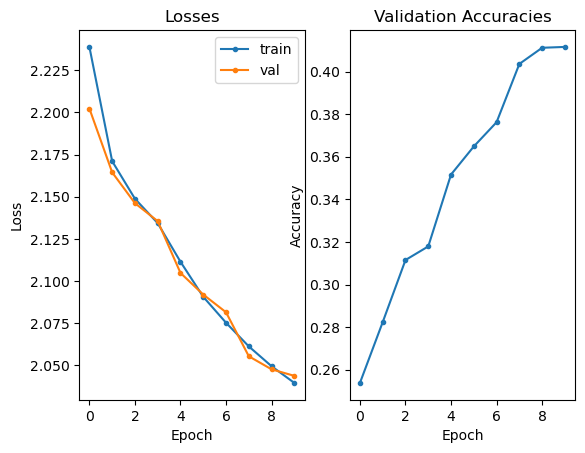

In [13]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=False, relu=False),
    torch.nn.CrossEntropyLoss(),
    torch.optim.Adam,
    mnist=False,
    epochs=10
)


Epoch 0, trainloss 0.07275063925254481, valloss 0.0664104509453934, valacc 0.4745592948717949
Epoch 1, trainloss 0.06342024712162264, valloss 0.06031805910289478, valacc 0.5346554487179487
Epoch 2, trainloss 0.05843230706783989, valloss 0.05675049517184305, valacc 0.5620993589743589
Epoch 3, trainloss 0.05483982515763783, valloss 0.057926978963689923, valacc 0.5568910256410257
Epoch 4, trainloss 0.052069947212288, valloss 0.05540877978245799, valacc 0.5775240384615384
Epoch 5, trainloss 0.049810425445946147, valloss 0.05434570816727594, valacc 0.5853365384615384
Epoch 6, trainloss 0.047826853683443575, valloss 0.054354228789750964, valacc 0.5903445512820513
Epoch 7, trainloss 0.04618855190558086, valloss 0.05717247757368172, valacc 0.5697115384615384
Epoch 8, trainloss 0.044476150186297886, valloss 0.053361849184745014, valacc 0.600761217948718
Epoch 9, trainloss 0.043092911125884086, valloss 0.05345163345695115, valacc 0.6059695512820513
Testacc 0.6009


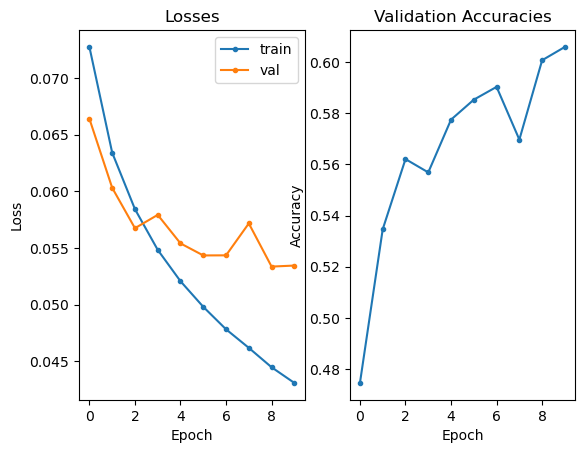

In [13]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=False),
    torch.nn.MSELoss(),
    torch.optim.Adam,
    mnist=False,
    epochs=10
)


Epoch 0, trainloss 0.08404026430227382, valloss 0.08130349507794166, valacc 0.30188301282051283
Epoch 1, trainloss 0.08063841901406921, valloss 0.07944523010593958, valacc 0.32371794871794873
Epoch 2, trainloss 0.0763291026787517, valloss 0.07341233540612918, valacc 0.3958333333333333
Epoch 3, trainloss 0.07147922739783993, valloss 0.06961446101419054, valacc 0.4417067307692308
Epoch 4, trainloss 0.06855231235108496, valloss 0.0672288024559235, valacc 0.47115384615384615
Epoch 5, trainloss 0.06604699217972702, valloss 0.06661592786892867, valacc 0.4733573717948718
Epoch 6, trainloss 0.06376947074132318, valloss 0.06410574046178506, valacc 0.49459134615384615
Epoch 7, trainloss 0.061751718528219, valloss 0.06507643935485528, valacc 0.4889823717948718
Epoch 8, trainloss 0.05998936468923456, valloss 0.06137000480427956, valacc 0.5232371794871795
Epoch 9, trainloss 0.058373686340856094, valloss 0.06065115977365237, valacc 0.5332532051282052
Testacc 0.5314


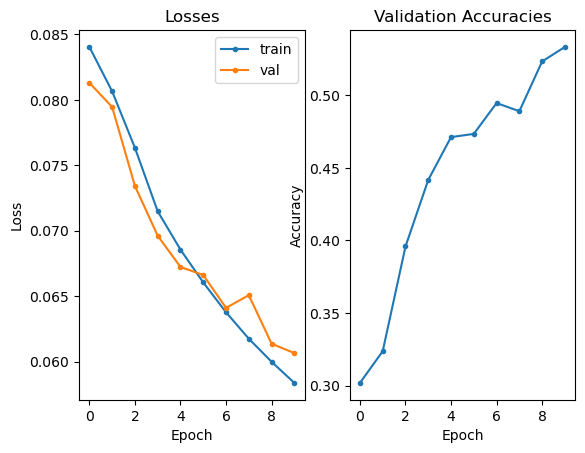

In [14]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=False, relu=False),
    torch.nn.MSELoss(),
    torch.optim.Adam,
    mnist=False,
    epochs=10
)


Epoch 0, trainloss 2.302499551267746, valloss 2.3024297134998517, valacc 0.09114583333333333
Epoch 1, trainloss 2.30241988351301, valloss 2.3023576522484803, valacc 0.09334935897435898
Epoch 2, trainloss 2.3023413575729976, valloss 2.302286594341963, valacc 0.09755608974358974
Epoch 3, trainloss 2.302260269820266, valloss 2.302212323897924, valacc 0.10416666666666667
Epoch 4, trainloss 2.3021731571656034, valloss 2.302129176946787, valacc 0.11177884615384616
Epoch 5, trainloss 2.302073909920954, valloss 2.3020334518872776, valacc 0.1219951923076923
Epoch 6, trainloss 2.301957423368185, valloss 2.3019185150280976, valacc 0.12860576923076922
Epoch 7, trainloss 2.301817987755386, valloss 2.3017767392672024, valacc 0.1294070512820513
Epoch 8, trainloss 2.3016467787124015, valloss 2.3015989317343784, valacc 0.12880608974358973
Epoch 9, trainloss 2.30143395214637, valloss 2.3013752553707514, valacc 0.12399839743589744
Testacc 0.123


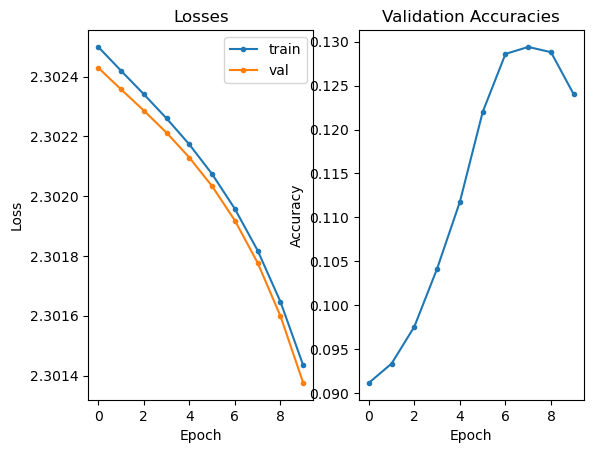

In [18]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=False),
    torch.nn.CrossEntropyLoss(),
    torch.optim.SGD,
    mnist=False,
    epochs=10
)


Epoch 0, trainloss 2.3032398758877393, valloss 2.302712930318637, valacc 0.1045673076923077
Epoch 1, trainloss 2.3031314866641166, valloss 2.302656061374224, valacc 0.1045673076923077
Epoch 2, trainloss 2.303046981945825, valloss 2.302618037431668, valacc 0.109375
Epoch 3, trainloss 2.3029762560748104, valloss 2.3025933649295416, valacc 0.09755608974358974
Epoch 4, trainloss 2.302923263815016, valloss 2.3025756165003166, valacc 0.09755608974358974
Epoch 5, trainloss 2.302876787368807, valloss 2.30256436421321, valacc 0.09755608974358974
Epoch 6, trainloss 2.3028357368105676, valloss 2.3025582012457724, valacc 0.09755608974358974
Epoch 7, trainloss 2.3028008345180693, valloss 2.3025566989030595, valacc 0.09755608974358974
Epoch 8, trainloss 2.3027710701798645, valloss 2.302557580746137, valacc 0.09755608974358974
Epoch 9, trainloss 2.3027439424357405, valloss 2.3025609644559712, valacc 0.09755608974358974
Testacc 0.1


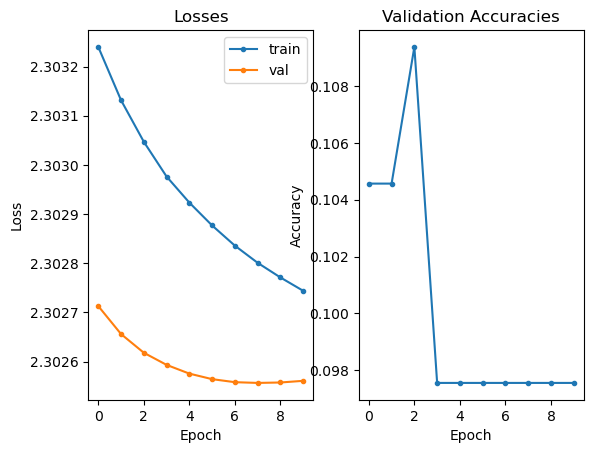

In [15]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=False, relu=False),
    torch.nn.CrossEntropyLoss(),
    torch.optim.SGD,
    mnist=False,
    epochs=10
)


Epoch 0, trainloss 0.09003774056563506, valloss 0.09005994891795592, valacc 0.09695512820512821
Epoch 1, trainloss 0.0900354921515729, valloss 0.09005743912301767, valacc 0.09695512820512821
Epoch 2, trainloss 0.09003310566065915, valloss 0.09005497204951751, valacc 0.09695512820512821
Epoch 3, trainloss 0.09003092052354074, valloss 0.09005253348881617, valacc 0.09695512820512821
Epoch 4, trainloss 0.09002863221230836, valloss 0.0900501294586903, valacc 0.09695512820512821
Epoch 5, trainloss 0.09002633576955683, valloss 0.09004775983973956, valacc 0.09695512820512821
Epoch 6, trainloss 0.09002426908130243, valloss 0.09004542288871911, valacc 0.09695512820512821
Epoch 7, trainloss 0.0900222289973438, valloss 0.09004310303582595, valacc 0.09695512820512821
Epoch 8, trainloss 0.0900200846238038, valloss 0.09004082012539491, valacc 0.09695512820512821
Epoch 9, trainloss 0.09001787909827226, valloss 0.09003857047989583, valacc 0.09695512820512821
Testacc 0.1


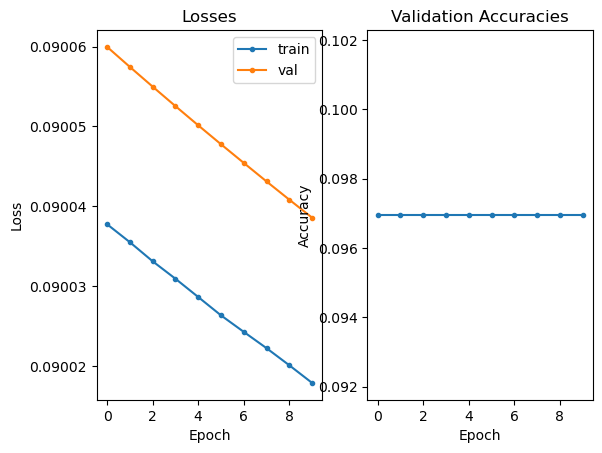

In [16]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=False),
    torch.nn.MSELoss(),
    torch.optim.SGD,
    mnist=False,
    epochs=10
)


Epoch 0, trainloss 0.0911063538442974, valloss 0.09083096470492773, valacc 0.1045673076923077
Epoch 1, trainloss 0.09066195662529505, valloss 0.09052484757147539, valacc 0.1045673076923077
Epoch 2, trainloss 0.09042141726969147, valloss 0.09034567648688188, valacc 0.1045673076923077
Epoch 3, trainloss 0.09027638041002313, valloss 0.09023253583850768, valacc 0.1045673076923077
Epoch 4, trainloss 0.0901835789032291, valloss 0.09015890726676354, valacc 0.1045673076923077
Epoch 5, trainloss 0.09012361738041234, valloss 0.09010962310891885, valacc 0.1045673076923077
Epoch 6, trainloss 0.09008308884503577, valloss 0.09007646933866617, valacc 0.1045673076923077
Epoch 7, trainloss 0.09005625926721232, valloss 0.09005397980889449, valacc 0.1045673076923077
Epoch 8, trainloss 0.09003798886709667, valloss 0.09003864649014595, valacc 0.11017628205128205
Epoch 9, trainloss 0.09002603579890169, valloss 0.09002820674616557, valacc 0.0999599358974359
Testacc 0.101


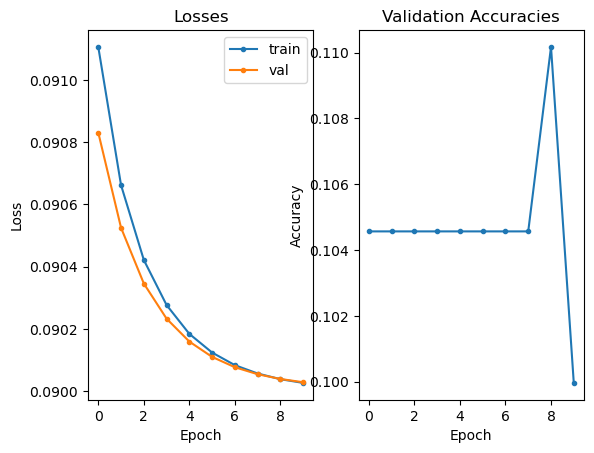

In [17]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=False, relu=False),
    torch.nn.MSELoss(),
    torch.optim.SGD,
    mnist=False,
    epochs=10
)


## Further investigating MSELoss vs CrossEntropyLoss

Epoch 0, trainloss 0.07164567198530157, valloss 0.0648434011098475, valacc 0.48657852564102566
Epoch 1, trainloss 0.061028381512178424, valloss 0.06022149196658761, valacc 0.5400641025641025
Epoch 2, trainloss 0.05619333789301016, valloss 0.057309458080010534, valacc 0.5556891025641025
Epoch 3, trainloss 0.05295177335105042, valloss 0.054528650284434356, valacc 0.5825320512820513
Epoch 4, trainloss 0.05057020472683235, valloss 0.05520774548252424, valacc 0.5805288461538461
Epoch 5, trainloss 0.04828912238053882, valloss 0.053560266724954814, valacc 0.6005608974358975
Epoch 6, trainloss 0.04643912786209842, valloss 0.054738252029682584, valacc 0.5837339743589743
Epoch 7, trainloss 0.044875860153541766, valloss 0.05391010938761517, valacc 0.5949519230769231
Epoch 8, trainloss 0.04339147573366767, valloss 0.05288446160296026, valacc 0.6029647435897436
Epoch 9, trainloss 0.041800056081589786, valloss 0.05311239941809804, valacc 0.6047676282051282
Epoch 10, trainloss 0.04058658435992409, va

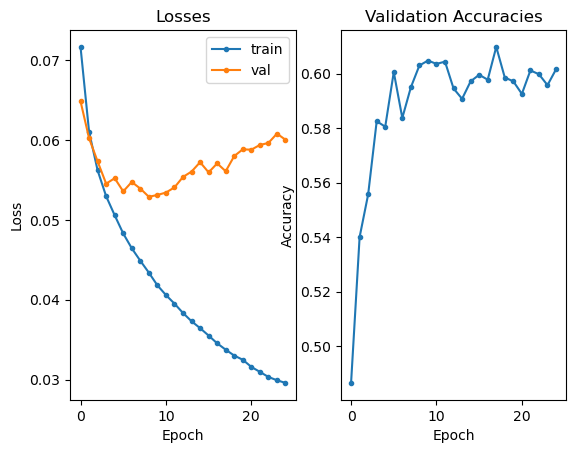

In [22]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=False, relu=True),
    torch.nn.MSELoss(),
    torch.optim.Adam,
    mnist=False,
    epochs=25
)


Epoch 0, trainloss 2.116153162794127, valloss 2.0418732235064874, valacc 0.41225961538461536
Epoch 1, trainloss 2.0244953309319604, valloss 2.011714824499228, valacc 0.4441105769230769
Epoch 2, trainloss 1.9883146052001042, valloss 1.9694630282047467, valacc 0.4855769230769231
Epoch 3, trainloss 1.9649879857367845, valloss 1.954685159600698, valacc 0.5018028846153846
Epoch 4, trainloss 1.9472137646773462, valloss 1.9440584450195997, valacc 0.5120192307692307
Epoch 5, trainloss 1.9312436957956207, valloss 1.9434530043449156, valacc 0.5154246794871795
Epoch 6, trainloss 1.9153527417783207, valloss 1.9302074378117537, valacc 0.5254407051282052
Epoch 7, trainloss 1.907368221416921, valloss 1.9196103475032709, valacc 0.5366586538461539
Epoch 8, trainloss 1.8942064494954403, valloss 1.9304797374285185, valacc 0.5272435897435898
Epoch 9, trainloss 1.8866329359296037, valloss 1.950562372039526, valacc 0.5040064102564102
Epoch 10, trainloss 1.8795021429848704, valloss 1.9161310876027131, valacc

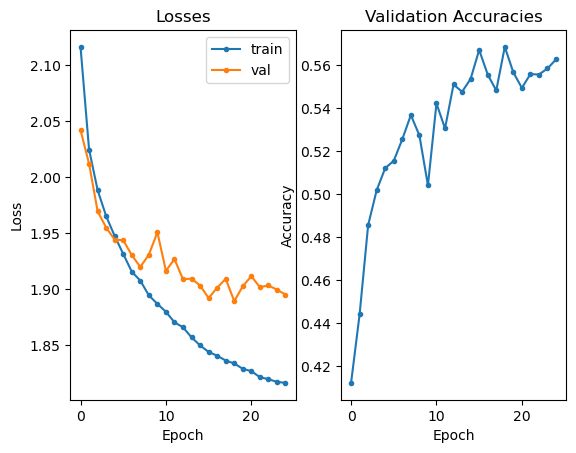

In [23]:
train_losses, val_losses, val_accs, test_acc = train(
    CNN(mnist=False, relu=True),
    torch.nn.CrossEntropyLoss(),
    torch.optim.Adam,
    mnist=False,
    epochs=25
)


# Report

## Running the code

The code is quite simple to run since it is all packaged in a single notebook. The function and variable names should be quite indicative of their respective purposes. As for the environment, refer to the `environment.yml` file that is provided. This represents the conda environment which was used to write and run the notebook. All required datasets are downloaded using the notebook itself.

## Model architectures and hyperparameters

The model architectures can be seen from the code above. As for the hyperparameters, we chose reasonable values based on trial-and-error in order to get the best performance. For our experiments, we decided to compare between the following:

* Loss: MSELoss vs CrossEntropyLoss
* Optimizer: SGD vs Adam
* Activation: ReLU vs Sigmoid

It should be noted that MSELoss generally gives smaller values than CrossEntropyLoss. Given a certain output and a certain label, the MSELoss will generally be lower than the CrossEntropyLoss on the same values. This is fine for optimization since we are finding the local minimum, however it does affect the speed of learning. Hence we use a higher learning rate for MSELoss and a lower learning rate for CrossEntropyLoss to compensate for the difference in magnitude.


## Experimental Results

The values shown in the tables below correspond to the final test accuracies of the models. Note that since both datasets correspond to classification problems with 10 classes, hence the expected accuracy of a naive random-guess model is 0.10. Any performance significantly better than 0.10 is proof that a model was trained well. 


### CNN on MNIST

ReLU Activation:

|                  | Adam Optimizer | SGD Optimizer |
|------------------|----------------|---------------|
| MSELoss          |      0.9881          |    0.1045           |
| CrossEntropyLoss |     0.9859           |    0.348           |

Sigmoid Activation:

|                  | Adam Optimizer | SGD Optimizer |
|------------------|----------------|---------------|
| MSELoss          |      0.9869          |    0.1135           |
| CrossEntropyLoss |        0.9845        |     0.1135          |

The best result was 0.9881 obtained with ReLU activation, Adam Optimizer, and MSELoss. In general we notice that SGD optimizer performs poorly compared to Adam. This might be because Adam optimizer is more versatile, adjusting the learning rate based on the situation and allowing different learning rates for different parameters. The poor performance of SGD is quite surprising, but we tried many different learning rates (differing in orders of magnitude) and no learning rate was able to give a good performance. We also notice that MSELoss performs better than CrossEntropyLoss, though the difference is insignificant. Finally we notice that ReLU generally performs better than Sigmoid, which makes sense as the Sigmoid function has a tendency to hinder learning when the weights have very large magnitudes.

### MLP on MNIST

We decided to train the MLP using the same settings (ReLU activation, Adam Optimizer, and MSELoss) as the best-performing CNN. The resultant test accuracy was  0.9709. This is a good performance but it is still noticeably worse than the CNNs; this observation is unsurprising as the filters of the CNN are specialized for extracting local features in images, which allows the CNN to learn more effectively than the MLP.



### CNN on CIFAR

ReLU Activation:

|                  | Adam Optimizer | SGD Optimizer |
|------------------|----------------|---------------|
| MSELoss          |      0.6009          |     0.1          |
| CrossEntropyLoss |     0.5368           |       0.123        |

Sigmoid Activation:

|                  | Adam Optimizer | SGD Optimizer |
|------------------|----------------|---------------|
| MSELoss          |     0.5314           |    0.101           |
| CrossEntropyLoss |      0.4193          |       0.1        |


The best result was 0.6009 obtained with MSELoss, Adam, and ReLU Activation. Overall SGD performed very poorly again, while ReLU and MSELoss were noted to perform better than Sigmoid and CrossEntropyLoss, respectively.

### MLP on CIFAR

We ran the MLP training with the same settings that gave us the best CNN performance ( MSELoss, Adam, and ReLU Activation). The result was 0.4562. This is a good performance but it is still noticeably worse than the CNNs; this observation is unsurprising as the filters of the CNN are specialized for extracting local features in images, which allows the CNN to learn more effectively than the MLP. What is surprising is that the MLP performed better than the CNN with Sigmoid activation, Adam Optimizer, and CrossEntropyLoss. It would imply that the CNN does not confer a very big advantage over the MLP.



## Overall comparisons

In general we notice that CNN is better than MLP, ReLU is better than Sigmoid, Adam is better than SGD, and MSELoss is better than CrossEntropyLoss. The first three observations are unsurprising and were discussed earlier. However it is quite surprising that MSELoss is better than CrossEntropyLoss since the latter is more commonly used in classification problems. Since we use different learning rates for MSELoss and CrossEntropyLoss, it is possible that the models simply had not converged and the difference in learning rates was the cause of the discrepancy. So we decided to investigate further by increasing the number of iterations to verify that this was not an issue of convergence. 

In the end, the CNN with MSE obtained a test accuracy of 0.6, which was no better than the previous attempt; there were also signs of overfitting as the validation loss began to increase after the 10th iteration (though the validation accuracy did not get worse). The CNN with CrossEntropyLoss obtained a test accuracy of 0.5646. This is better than the previous performance, but still no better than the MSELoss model. This proves that the difference in performance is not due to faster convergence caused by a higher learning rate for the MSELoss model. 
